In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import Counter , deque
import hashlib

In [8]:
# def build_states_table():

#     StatesMatrix = np.zeros((3**9, 9))
#     for i in range(3**9):
#         c = i
#         for j in range(9):
#            StatesMatrix[i][j] = c % 3
#            c //= 3
#     StatesMatrix1 = np.zeros((5814, 9))
#     k = 0
#     for i in range(0, StatesMatrix.shape[0]):
#       if (np.count_nonzero(StatesMatrix[i] == 1) - np. count_nonzero(StatesMatrix[i] == 2)) == 1 or (np. count_nonzero(StatesMatrix[i] == 2) - np. count_nonzero(StatesMatrix[i] == 1)) == 1:
#         StatesMatrix1[k] = StatesMatrix[i]
#         k = k + 1
#     StatesMatrix1 = StatesMatrix1.reshape((5814, 3, 3))
#     states_dict = {}
#     for i in range(5814):
#         states_dict[hash(str(StatesMatrix1[i].flatten()))] = i# all zeros
#     states_dict[hash(str(np.zeros((3, 3), dtype=np.float16).flatten()))] = 5814
#     return states_dict

def save_states_pickle(states_dict):
    """ save the dictionaly in a pickle file

    Args:
        states_dict (dict): the dictionary that has all the hashed states
    """
    with open("my_dict"+ '.pickle', 'wb') as f:
        pickle.dump(states_dict, f, pickle.HIGHEST_PROTOCOL)

def load_states_pickle():
    """
        loads the states_dictionary
    Returns:
        dict: the loaded dictionary
    """
    with open("my_dict" + '.pickle', 'rb') as f:
        return pickle.load(f)

    

In [28]:
states_dict = load_states_pickle()
print("Currently Saved States number = " , len(states_dict))
class MyBoard(object):
    def __init__(self):
            
        self.board = np.zeros((3, 3), dtype=np.float16)
        self.actions_dict = {0: [0, 0], 1: [0, 1], 2: [0, 2],
                             3: [1, 0], 4: [1, 1], 5: [1, 2],
                             6: [2, 0],  7: [2, 1], 8: [2, 2]}
        self.agent = 1
        self.other_agent = 2
        self.i = len(states_dict)

    def get_current_state(self):    
        """
            get the current state , by converting the current board into it's state number from the states dict
            if it's Not in the dict , it adds it and expands the Q_learning
        Returns:
            _type_: _description_
        """
        state_key = int(hashlib.sha512(str((self.board.flatten())).encode('utf-8')).hexdigest(), 16)

        try:
            return states_dict[state_key]
        except:
            Agent.Q_table = np.concatenate((Agent.Q_table , np.zeros((3,3)).flatten().reshape(1,9)) , axis=0)

            states_dict[state_key] = self.i
            self.i += 1
            return states_dict[state_key]

    def put_on_board(self, player, action):
        """

        Args:
            player (int ): 1 for agent , 2 for human
            action (int 0 to 8): one of the 9 actions , which corresponds  
        Raises:
            Exception: already placed if you try to put in a place that has value

        Returns:
            int: new_state
        """
        x, y = self.actions_dict[action]
        if self.board[x][y] == 0:
            self.board[x][y] = player
        else:
            print(board.board)
            print(board.getAvailableMoves())
            raise Exception("already placed")
        return self.get_current_state()

    def check_end(self):
        """
        check if game is over
        Returns: 
            int: 1 if agent won , 2 if Lost , 0 if game is not over , "Tie" if game is a tie
        """
        for i in range(3):
            if self.board[0][i] == self.board[1][i] and self.board[1][i] == self.board[2][i] and self.board[0][i] != 0:
                return self.board[0][i]
            elif self.board[i][0] == self.board[i][1] and self.board[i][1] == self.board[i][2] and self.board[i][0] != 0:
                return self.board[i][0]

        if self.board[0][0] == self.board[1][1] and self.board[1][1] == self.board[2][2] and self.board[0][0] != 0:
            return self.board[0][0]
        elif self.board[0][2] == self.board[1][1] and self.board[1][1] == self.board[2][0] and self.board[0][2] != 0:
            return self.board[0][2]
        if len(np.where(self.board == 0)[0]) == 0:
            return "Tie"
        else:
            return 0

    def step(self, action_index , player):
        """

        Args:
            action_index (int): The Action index to be converted into r,c to put X or O in it
            player (int): The current Player , 1 for X , 2 for O 

        Returns:
            tuple(new_state , reward , done)
        """
        new_state = self.put_on_board(player, action_index)
        reward = 0
        done = False

        if self.check_end() == 1:
            reward = 10
            done = True
        elif self.check_end() == 2:
            reward = -10
            done = True
        elif self.check_end() == "Tie":
            reward = 1
            done = True
        return new_state, reward, done

    def resetEnvironment(self):
        """
        resets the board to all zeros
        """
        self.board = np.zeros((3, 3), dtype=np.float16)

    def getAvailableMoves(self):
        """
        get r,c of available moves then convert to action index

        Returns:
            list : of all free action indecies
        """
        free_moves = []
        x, y = np.where(self.board == 0)
        for i, j in zip(x, y):
            free_moves.append((i*3 + j))
        return free_moves
    def put(self , x , y):
        """for me to test playing against the ai"""
        self.board[x][y] = 2


Currently Saved States number =  30598


In [22]:
class Agent(object):
    Q_table = np.zeros((len(states_dict) , 9))
    def __init__(self, lr, dr, n_actions):
        self.lr = lr
        self.discount_rate = dr
        self.epsilon = 1
        self.n_actions = n_actions
        self.train_rewards = deque([])
        self.wins = deque([])
        self.losses = deque([])
        self.ties = deque([])
        self.decay_rate = 0.000001

    def epsilon_greedy(self, state , env , Qtable , player):
        if player == 1:
            action = 0
            if np.random.rand(1) < self.epsilon:
                current_state = env.get_current_state()
                available_moves = env.getAvailableMoves()
                maximum_val = -10000

                for i in range(9):
                    if i in available_moves:
                        if Agent.Q_table[current_state][i] >= maximum_val:
                            maximum_val =  Agent.Q_table[current_state][i]
                            action = i
            else:
                free_moves = env.getAvailableMoves()
                action = np.random.choice(free_moves)
            return action
        elif player==2 :
            action = 0
            if np.random.rand(1) < self.epsilon:
                current_state = env.get_current_state()
                available_moves = env.getAvailableMoves()
                min_val = 10000

                for i in range(9):
                    if i in available_moves:
                        if Agent.Q_table[current_state][i] <= min_val:
                            min_val =  Agent.Q_table[current_state][i]
                            action = i
            else:
                free_moves = env.getAvailableMoves()
                action = np.random.choice(free_moves)
            return action

    def exp_epsilon_greedy(self, state , env , Qtable , player):
        if player == 1:
            action = 0
            if np.random.rand(1) > self.epsilon:
                current_state = env.get_current_state()
                available_moves = env.getAvailableMoves()
                maximum_val = -10000

                for i in range(9):
                    if i in available_moves:
                        if Agent.Q_table[current_state][i] >= maximum_val:
                            maximum_val =  Agent.Q_table[current_state][i]
                            action = i
            else:
                free_moves = env.getAvailableMoves()
                action = np.random.choice(free_moves)
            return action
        elif player==2 :
            action = 0
            if np.random.rand(1) > self.epsilon:
                current_state = env.get_current_state()
                available_moves = env.getAvailableMoves()
                min_val = 10000

                for i in range(9):
                    if i in available_moves:
                        if Agent.Q_table[current_state][i] <= min_val:
                            min_val =  Agent.Q_table[current_state][i]
                            action = i
            else:
                free_moves = env.getAvailableMoves()
                action = np.random.choice(free_moves)
            return action
    def train(self, env, n_games):
        policy_buffer = deque([Agent.Q_table])
        old_state = env.resetEnvironment()
        enemy_q_table = policy_buffer[np.random.choice(len(policy_buffer))]
        for game in range(n_games):
            action = self.exp_epsilon_greedy(old_state, env, Agent.Q_table , player = 1)
            new_state, reward, done = env.step(action, player=1)
            if done:
                    Agent.Q_table[old_state, action] += self.lr * (reward - Agent.Q_table[old_state, action])
            else:
                    
                    enemy_action = self.exp_epsilon_greedy(
                        old_state, env, enemy_q_table , player=2)
                    new_state, reward, done = env.step(enemy_action, player=2)
                    Agent.Q_table[old_state, action] += self.lr * (reward + (self.discount_rate * np.max(
                        Agent.Q_table[new_state, :])) - Agent.Q_table[old_state, action])
                    old_state = new_state

                    
            if done:
                    self.train_rewards.append(env.check_end())
                    env.resetEnvironment()
                    old_state = 0
            else:
                    old_state = new_state
            self.epsilon = np.exp(-game * self.decay_rate)        
            if game % 10000 == 0:
                    enemy_q_table = policy_buffer[np.random.choice(
                        len(policy_buffer))]
                    print(" Iteration : ", game)
                    print(" Epsilon : " , self.epsilon)
                    # save the Q table every 5000 games
                    policy_buffer.append(Agent.Q_table)
                    if len(policy_buffer) == 7:  # keep the last 5 Q tables
                        policy_buffer.popleft()  # remove the oldest policy

                    counter = Counter(self.train_rewards) 
                    n_games_won = counter[1]
                    n_games_lost = counter[2]
                    n_games_Tie = counter['Tie']
                    print(f"Number of Games Won : {n_games_won}")
                    print(f"Number Of Games Tied :   {n_games_Tie}")
                    print(f"Number Of Games Lost :   {n_games_lost}")

                    self.wins.append(n_games_won)
                    self.losses.append(n_games_lost)
                    self.ties.append(n_games_Tie)


        save_states_pickle(states_dict)



In [24]:
board = MyBoard()
agent = Agent( lr = 1 , dr = 0.8 , n_actions = 9)


In [25]:
agent.train(board , 2000000)

 Iteration :  0
 Epsilon :  1.0
Number of Games Won : 0
Number Of Games Tied :   0
Number Of Games Lost :   0
 Iteration :  10000
 Epsilon :  0.9900498337491681
Number of Games Won : 1406
Number Of Games Tied :   290
Number Of Games Lost :   708
 Iteration :  20000
 Epsilon :  0.9801986733067553
Number of Games Won : 2814
Number Of Games Tied :   606
Number Of Games Lost :   1391
 Iteration :  30000
 Epsilon :  0.9704455335485082
Number of Games Won : 4239
Number Of Games Tied :   888
Number Of Games Lost :   2107
 Iteration :  40000
 Epsilon :  0.9607894391523232
Number of Games Won : 5727
Number Of Games Tied :   1152
Number Of Games Lost :   2776
 Iteration :  50000
 Epsilon :  0.951229424500714
Number of Games Won : 7218
Number Of Games Tied :   1445
Number Of Games Lost :   3418
 Iteration :  60000
 Epsilon :  0.9417645335842487
Number of Games Won : 8698
Number Of Games Tied :   1717
Number Of Games Lost :   4089
 Iteration :  70000
 Epsilon :  0.9323938199059483
Number of Games 

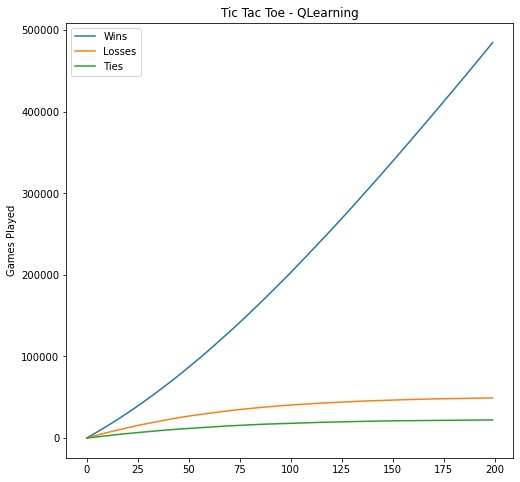

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.title("Tic Tac Toe - QLearning")
plt.ylabel("Games Played")
plt.plot(agent.wins )
plt.plot(agent.losses)
plt.plot(agent.ties)
plt.legend(["Wins" , "Losses" , "Ties"])

In [32]:
import time
board.resetEnvironment()
old_state = 0
board=MyBoard()
while board.check_end() == 0:
    print(Agent.Q_table[old_state])
    print(f'epsilon {agent.epsilon}')
    action = agent.exp_epsilon_greedy(old_state, board, Agent.Q_table , player = 1)
    new_state, reward, done = board.step(action, player=1)
    print(board.board)
    if done : 
        if board.check_end() != 'Tie':
            print(f'{board.check_end()} wins !')
        board.resetEnvironment()
    
    #take x , y as int inputs 
    x = int(input())
    y=int(input())
    board.put(x,y)

    if done : 
        if board.check_end() != 'Tie':
            print(f'{board.check_end()} wins !')
        board.resetEnvironment()
    old_state = board.get_current_state()
    

[6.4 6.4 6.4 6.4 6.4 6.4 6.4 6.4 6.4]
epsilon 0.13533541857196363
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
[6.4 6.4 0.  6.4 6.4 6.4 6.4 6.4 0. ]
epsilon 0.13533541857196363
[[0. 0. 2.]
 [0. 0. 0.]
 [0. 1. 1.]]
[  8.    8.    0.    6.4   8.  -10.    0.    0.    0. ]
epsilon 0.13533541857196363
[[0. 0. 2.]
 [0. 1. 0.]
 [2. 1. 1.]]
[10.  0.  0.  8.  0.  8.  0.  0.  0.]
epsilon 0.13533541857196363
[[1. 2. 2.]
 [0. 1. 0.]
 [2. 1. 1.]]
1.0 wins !


ValueError: invalid literal for int() with base 10: ''

In [1]:
#done